<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/HistoryMatching_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install jcopml "jcopdl<2.0"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
df = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/01_df_merged.csv', index_col="years")
df['oil_prod_cum'] = df['oil_prod_cum'] * 1e-5
df.head()

case_num  days  oil_prod_rate  oil_prod_cum  water_inj_rate  \
years                                                                   
0.000000         0     0            0.0       0.00000            0.00   
0.084932         0    31        26614.0       8.25035         1740.71   
0.169863         0    62        21427.7      14.89290         1740.71   
0.254795         0    93        18809.7      20.72390         1740.71   
0.339726         0   124        16676.6      25.89370         1740.71   

          water_inj_cum category      Kh_Kv     inj_rate  permeability  \
years                                                                    
0.000000            0.0    train  16.423475  1740.711355    288.983333   
0.084932        53962.1    train  16.423475  1740.711355    288.983333   
0.169863       107924.0    train  16.423475  1740.711355    288.983333   
0.254795       161886.0    train  16.423475  1740.711355    288.983333   
0.339726       215848.0    train  16.423475  1740.711355    288.983333   

          porosity    prod_bhp  thickness  
years                                      
0.000000  0.163009  796.992254  23.718632  
0.084932  0.163009  796.992254  23.718632  
0.169863  0.163009  796.992254  23.718632  
0.254795  0.163009  796.992254  23.718632  
0.339726  0.163009  796.992254  23.718632

In [5]:
df.drop(columns=["oil_prod_rate", 'water_inj_rate', 'water_inj_cum', 'category'], inplace = True)

In [6]:
df1 = df.copy()
df1.head()

case_num  days  oil_prod_cum      Kh_Kv     inj_rate  permeability  \
years                                                                          
0.000000         0     0       0.00000  16.423475  1740.711355    288.983333   
0.084932         0    31       8.25035  16.423475  1740.711355    288.983333   
0.169863         0    62      14.89290  16.423475  1740.711355    288.983333   
0.254795         0    93      20.72390  16.423475  1740.711355    288.983333   
0.339726         0   124      25.89370  16.423475  1740.711355    288.983333   

          porosity    prod_bhp  thickness  
years                                      
0.000000  0.163009  796.992254  23.718632  
0.084932  0.163009  796.992254  23.718632  
0.169863  0.163009  796.992254  23.718632  
0.254795  0.163009  796.992254  23.718632  
0.339726  0.163009  796.992254  23.718632

In [7]:
df1.drop(columns = 'case_num', inplace = True)
df1.head()

days  oil_prod_cum      Kh_Kv     inj_rate  permeability  porosity  \
years                                                                          
0.000000     0       0.00000  16.423475  1740.711355    288.983333  0.163009   
0.084932    31       8.25035  16.423475  1740.711355    288.983333  0.163009   
0.169863    62      14.89290  16.423475  1740.711355    288.983333  0.163009   
0.254795    93      20.72390  16.423475  1740.711355    288.983333  0.163009   
0.339726   124      25.89370  16.423475  1740.711355    288.983333  0.163009   

            prod_bhp  thickness  
years                            
0.000000  796.992254  23.718632  
0.084932  796.992254  23.718632  
0.169863  796.992254  23.718632  
0.254795  796.992254  23.718632  
0.339726  796.992254  23.718632

In [8]:
ts_train, ts_test = train_test_split(df1, test_size=0.3, shuffle = False)
ts_train.shape, ts_test.shape

((84700, 8), (36300, 8))

In [9]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import TensorDataset, DataLoader

In [10]:
seq_len = 60
bs = 16

train_set = TimeSeriesDataset(ts_train, 'oil_prod_cum', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'oil_prod_cum', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (1411, 60, 8)
Note: last 39 data excluded

(N, S, F): (604, 60, 8)
Note: last 59 data excluded



In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout = dropout, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc (x)
        return x, hidden

In [12]:
train_set.n_seq

60

In [13]:
config = set_config({
    'input_size': train_set.n_feature,
    'seq_len': train_set.n_seq,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0,
    'output_size': 1,
})

In [14]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
callback = Callback(model, config)

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 44846.3290 | Test_cost  = 46014.1012 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 43412.2166 | Test_cost  = 44872.4842 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 42334.1343 | Test_cost  = 43813.7960 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 41315.6877 | Test_cost  = 42800.4806 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 40335.9703 | Test_cost  = 41821.4850 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 39387.6464 | Test_cost  = 40871.9178 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 38467.0727 | Test_cost  = 39949.0185 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 37572.0428 | Test_cost  = 39050.9759 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 36701.0451 | Test_cost  = 38176.4886 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 35852.9338 | Test_cost  = 37324.5380 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 35026.7996 | Test_cost  = 36494.2836 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 34221.8740 | Test_cost  = 35685.0206 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 33437.4964 | Test_cost  = 34896.1180 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 32673.0809 | Test_cost  = 34127.0209 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 31928.0986 | Test_cost  = 33377.2197 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 31202.0647 | Test_cost  = 32646.2436 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 30494.5276 | Test_cost  = 31933.6564 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 29805.0674 | Test_cost  = 31239.0515 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 29133.2893 | Test_cost  = 30562.0410 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 28478.8214 | Test_cost  = 29902.2588 | 


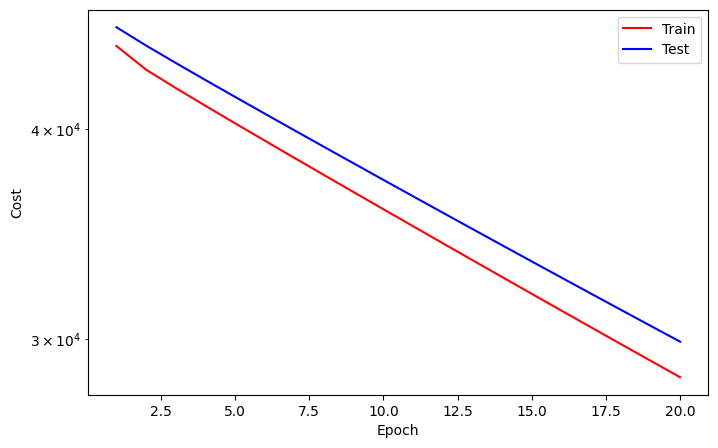

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 27841.3099 | Test_cost  = 29259.3677 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 27220.4178 | Test_cost  = 28633.0257 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 26615.8234 | Test_cost  = 28022.9259 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 26027.2165 | Test_cost  = 27428.7440 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 25454.2938 | Test_cost  = 26850.2151 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 24896.7949 | Test_cost  = 26287.0615 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 24354.4353 | Test_cost  = 25738.9955 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 23826.9229 | Test_cost  = 25205.7491 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 23312.7532 | Test_cost  = 24680.0628 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 22805.4920 | Test_cost  = 24169.4530 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 22308.6740 | Test_cost  = 23643.1712 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 21746.0787 | Test_cost  = 23042.6303 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 21192.6015 | Test_cost  = 22532.2743 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 20718.3574 | Test_cost  = 22066.1054 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 20248.3760 | Test_cost  = 21571.4720 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 19774.8920 | Test_cost  = 21106.4363 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 19315.6859 | Test_cost  = 20628.6683 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 18864.9917 | Test_cost  = 20189.0187 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 18442.2076 | Test_cost  = 19739.5334 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 18002.0462 | Test_cost  = 19318.3410 | 


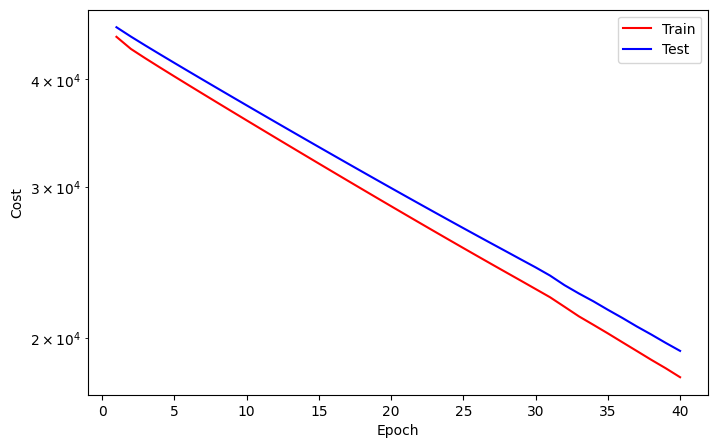

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 17607.4101 | Test_cost  = 18905.7723 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 17211.3025 | Test_cost  = 18520.8071 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 16806.1635 | Test_cost  = 18099.8441 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 16427.3817 | Test_cost  = 17710.5113 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 16040.6270 | Test_cost  = 17340.5471 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 15671.1444 | Test_cost  = 16950.7554 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 15313.5236 | Test_cost  = 16590.4042 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 14967.9084 | Test_cost  = 16244.8851 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 14619.5255 | Test_cost  = 15901.9271 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 14288.0569 | Test_cost  = 15558.7459 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 13961.5698 | Test_cost  = 15225.3659 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 13639.1295 | Test_cost  = 14910.6945 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 13334.9824 | Test_cost  = 14601.9874 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 13036.9070 | Test_cost  = 14287.5045 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 12734.7712 | Test_cost  = 13985.2839 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 12441.8122 | Test_cost  = 13682.3755 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 12155.9579 | Test_cost  = 13405.9111 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 11878.2303 | Test_cost  = 13140.8306 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 11605.9179 | Test_cost  = 12877.2637 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 11342.9035 | Test_cost  = 12569.0298 | 


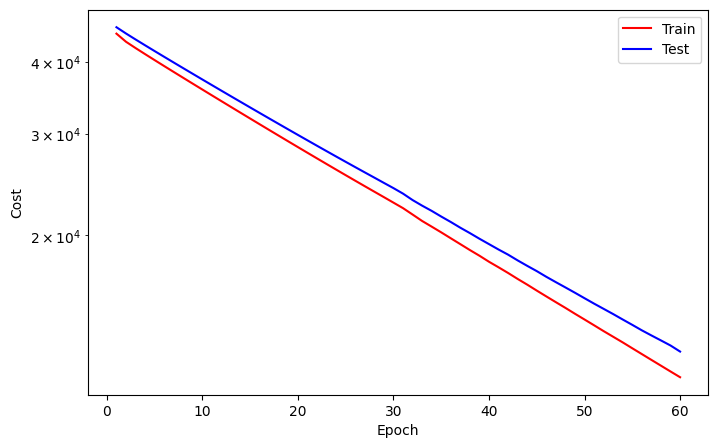

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 11075.4967 | Test_cost  = 12323.2752 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 10842.4261 | Test_cost  = 12064.8486 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 10574.8435 | Test_cost  = 11835.5213 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 10348.8355 | Test_cost  = 11588.1738 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 10135.1540 | Test_cost  = 11346.3329 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 9889.7728 | Test_cost  = 11100.9643 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 9659.6252 | Test_cost  = 10856.9807 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 9434.6640 | Test_cost  = 10634.8746 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 9227.9092 | Test_cost  = 10442.9907 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 9014.4192 | Test_cost  = 10193.1679 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 8801.4269 | Test_cost  = 10032.4611 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 8616.0857 | Test_cost  = 9775.9343 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 8403.6648 | Test_cost  = 9565.7145 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 8215.0757 | Test_cost  = 9382.7698 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 8027.8606 | Test_cost  = 9188.2696 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 7854.1133 | Test_cost  = 9018.4660 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 7671.1761 | Test_cost  = 8827.5344 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 7524.1054 | Test_cost  = 8657.7583 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 7342.1725 | Test_cost  = 8479.4499 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 7178.5048 | Test_cost  = 8293.6139 | 


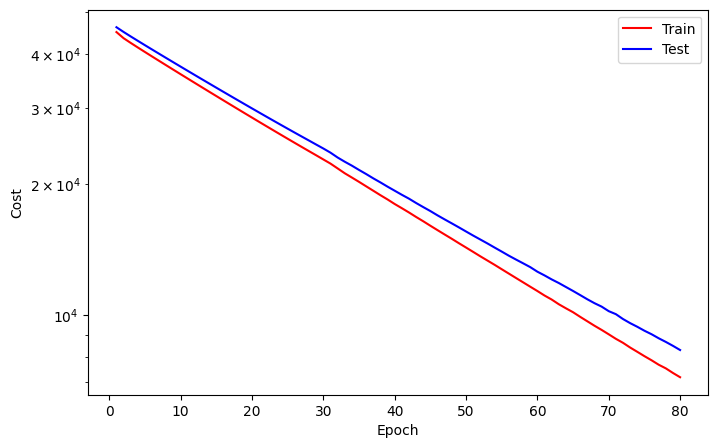

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 7020.4597 | Test_cost  = 8127.9916 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 6888.4788 | Test_cost  = 7988.8648 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 6718.7812 | Test_cost  = 7840.7716 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 6571.6337 | Test_cost  = 7663.9181 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 6413.4828 | Test_cost  = 7524.9403 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 6273.8491 | Test_cost  = 7350.6253 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 6123.2323 | Test_cost  = 7190.5384 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 5999.0280 | Test_cost  = 7079.5624 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 5887.6317 | Test_cost  = 6970.4646 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 5760.8443 | Test_cost  = 6805.1846 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 5657.3249 | Test_cost  = 6690.2279 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 5531.4079 | Test_cost  = 6605.7397 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 5474.3057 | Test_cost  = 6450.6090 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 5312.6016 | Test_cost  = 6337.0260 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 5205.2428 | Test_cost  = 6181.3145 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 5089.5646 | Test_cost  = 6071.0946 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 4954.3141 | Test_cost  = 5960.3051 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 4843.6026 | Test_cost  = 5817.7863 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 4720.4302 | Test_cost  = 5697.2602 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 4631.4492 | Test_cost  = 5601.4397 | 


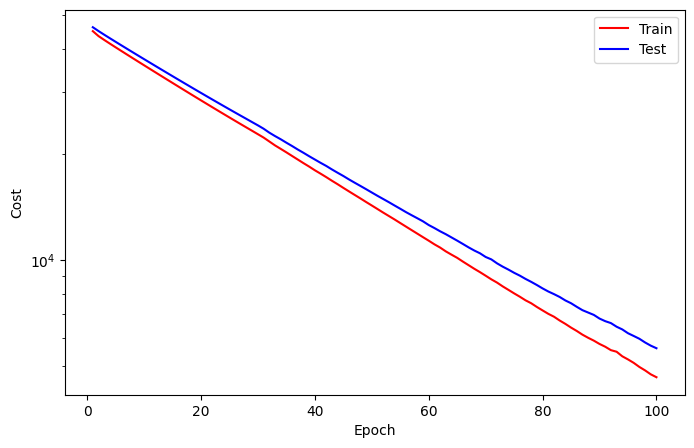

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 4546.7105 | Test_cost  = 5495.2678 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 4447.7477 | Test_cost  = 5405.3056 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 4372.5316 | Test_cost  = 5302.4834 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 4261.2570 | Test_cost  = 5203.4621 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 4151.8271 | Test_cost  = 5071.7042 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 4065.2625 | Test_cost  = 4958.7994 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 3985.4544 | Test_cost  = 4880.4692 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 3886.6653 | Test_cost  = 4789.1574 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 3803.8001 | Test_cost  = 4677.1322 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 3733.1255 | Test_cost  = 4622.8562 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 3647.3238 | Test_cost  = 4505.6457 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 3551.6706 | Test_cost  = 4424.5877 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 3475.0230 | Test_cost  = 4364.7442 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 3416.1089 | Test_cost  = 4272.8453 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 3362.3475 | Test_cost  = 4183.8138 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 3273.3419 | Test_cost  = 4100.5809 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 3202.2776 | Test_cost  = 4011.6811 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 3222.8349 | Test_cost  = 4037.4088 | 
==> EarlyStop patience =  1 | Best test_cost: 4011.6811


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 3129.1158 | Test_cost  = 3915.7853 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 3081.3463 | Test_cost  = 3833.7658 | 


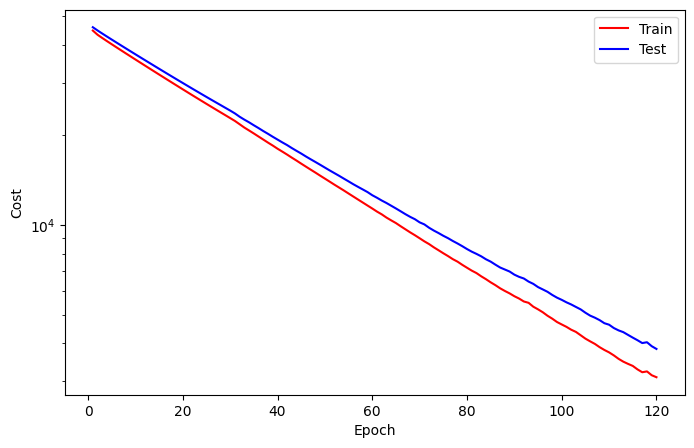

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 2979.9875 | Test_cost  = 3785.1736 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 2922.4908 | Test_cost  = 3717.9989 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 2886.5487 | Test_cost  = 3666.3203 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 2811.2816 | Test_cost  = 3547.0860 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 2782.7613 | Test_cost  = 3534.4377 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 2721.7733 | Test_cost  = 3458.9992 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 2658.5820 | Test_cost  = 3377.6924 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 2594.7131 | Test_cost  = 3323.9655 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 2535.1452 | Test_cost  = 3250.9728 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 2482.1919 | Test_cost  = 3181.1296 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 2429.0315 | Test_cost  = 3123.2271 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 2381.5956 | Test_cost  = 3062.5932 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 2332.9816 | Test_cost  = 3007.3714 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 2280.6627 | Test_cost  = 2954.3280 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 2240.9473 | Test_cost  = 2898.4449 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 2200.0264 | Test_cost  = 2844.6224 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 2158.8699 | Test_cost  = 2793.6046 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 2118.6925 | Test_cost  = 2754.4025 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 2071.8586 | Test_cost  = 2710.9715 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 2042.5628 | Test_cost  = 2648.5124 | 


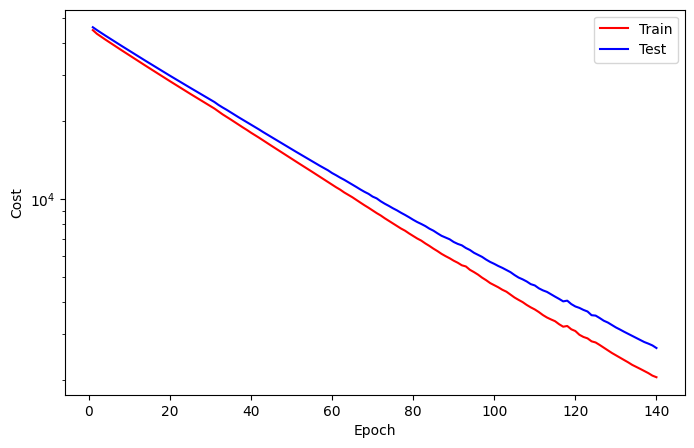

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 1998.3269 | Test_cost  = 2607.5637 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 1958.7201 | Test_cost  = 2560.1103 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 1925.9450 | Test_cost  = 2523.8333 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 1882.8861 | Test_cost  = 2467.9856 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 1847.8836 | Test_cost  = 2429.6090 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 1830.0345 | Test_cost  = 2395.3285 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 1787.1807 | Test_cost  = 2350.7489 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 1780.9744 | Test_cost  = 2373.3741 | 
==> EarlyStop patience =  1 | Best test_cost: 2350.7489


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 1764.8282 | Test_cost  = 2318.9740 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 1739.3656 | Test_cost  = 2279.6549 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 1681.4730 | Test_cost  = 2202.4808 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 1650.3215 | Test_cost  = 2170.3953 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 1623.8875 | Test_cost  = 2137.1274 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 1591.2813 | Test_cost  = 2096.0163 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 1560.0626 | Test_cost  = 2067.4888 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 1541.4218 | Test_cost  = 2048.5225 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 1512.9091 | Test_cost  = 2001.9726 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 1510.8829 | Test_cost  = 1977.5941 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 1466.3514 | Test_cost  = 1951.6732 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 1441.8170 | Test_cost  = 1914.6173 | 


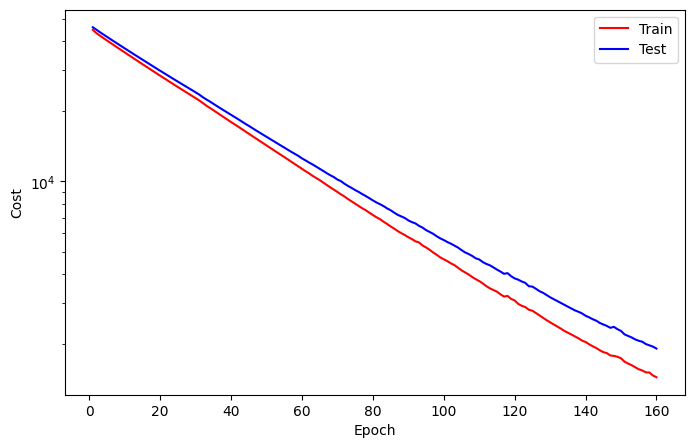

Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 1414.1093 | Test_cost  = 1880.5309 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 1402.0033 | Test_cost  = 1867.2558 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 1402.9961 | Test_cost  = 1848.5354 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 1392.6247 | Test_cost  = 1864.5981 | 
==> EarlyStop patience =  1 | Best test_cost: 1848.5354


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 1366.9655 | Test_cost  = 1791.4710 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 1384.6999 | Test_cost  = 1796.0468 | 
==> EarlyStop patience =  1 | Best test_cost: 1791.4710


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 1324.2258 | Test_cost  = 1767.2713 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 1337.2837 | Test_cost  = 1778.0304 | 
==> EarlyStop patience =  1 | Best test_cost: 1767.2713


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 1384.5547 | Test_cost  = 1942.5485 | 
==> EarlyStop patience =  2 | Best test_cost: 1767.2713


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 1380.8331 | Test_cost  = 1746.3840 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 1278.9104 | Test_cost  = 1672.1101 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 1242.0119 | Test_cost  = 1647.0429 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 1231.2937 | Test_cost  = 1613.3899 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 1208.8355 | Test_cost  = 1632.0715 | 
==> EarlyStop patience =  1 | Best test_cost: 1613.3899


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 1225.7796 | Test_cost  = 1603.5962 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 1201.6327 | Test_cost  = 1569.3032 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 1163.3762 | Test_cost  = 1548.8310 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 1139.4577 | Test_cost  = 1504.0215 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 1131.2875 | Test_cost  = 1509.2210 | 
==> EarlyStop patience =  1 | Best test_cost: 1504.0215


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 1144.4414 | Test_cost  = 1504.2103 | 


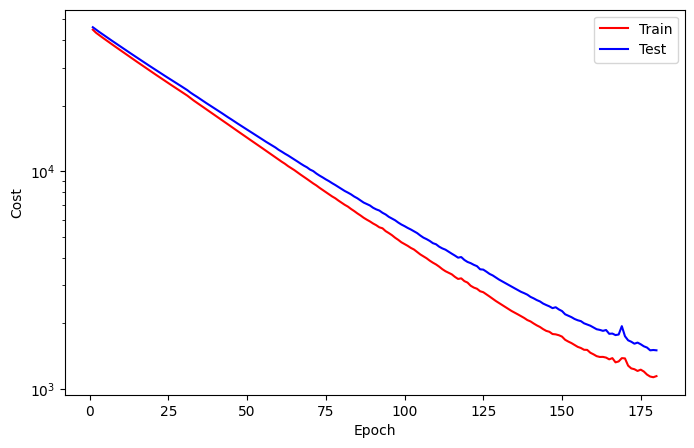

==> EarlyStop patience =  2 | Best test_cost: 1504.0215


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 1121.0484 | Test_cost  = 1484.0665 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 1127.6067 | Test_cost  = 1549.1646 | 
==> EarlyStop patience =  1 | Best test_cost: 1484.0665


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 1141.3789 | Test_cost  = 1452.4201 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 1126.4185 | Test_cost  = 1450.5328 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 1095.8050 | Test_cost  = 1413.1539 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 1053.3598 | Test_cost  = 1385.9736 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 1062.4588 | Test_cost  = 1406.6296 | 
==> EarlyStop patience =  1 | Best test_cost: 1385.9736


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 1123.3426 | Test_cost  = 1412.8264 | 
==> EarlyStop patience =  2 | Best test_cost: 1385.9736


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 1073.1107 | Test_cost  = 1388.2229 | 
==> EarlyStop patience =  3 | Best test_cost: 1385.9736


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 1097.5142 | Test_cost  = 1370.6841 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 1046.9587 | Test_cost  = 1357.4035 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 1132.1472 | Test_cost  = 1459.5574 | 
==> EarlyStop patience =  1 | Best test_cost: 1357.4035


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 1210.8406 | Test_cost  = 1696.0205 | 
==> EarlyStop patience =  2 | Best test_cost: 1357.4035


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 1185.6875 | Test_cost  = 1446.6338 | 
==> EarlyStop patience =  3 | Best test_cost: 1357.4035


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 1087.5662 | Test_cost  = 1349.2407 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 1058.9935 | Test_cost  = 1366.1972 | 
==> EarlyStop patience =  1 | Best test_cost: 1349.2407


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 1063.0753 | Test_cost  = 1311.0759 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 1056.4453 | Test_cost  = 1315.1548 | 
==> EarlyStop patience =  1 | Best test_cost: 1311.0759


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 1020.4222 | Test_cost  = 1326.3299 | 
==> EarlyStop patience =  2 | Best test_cost: 1311.0759


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 1047.3953 | Test_cost  = 1357.2769 | 


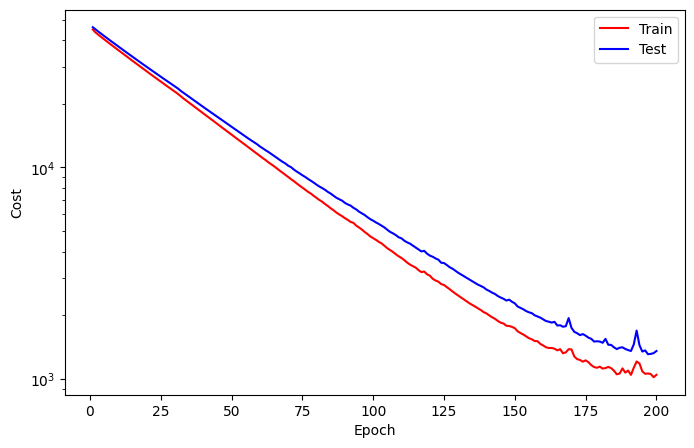

==> EarlyStop patience =  3 | Best test_cost: 1311.0759


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 1015.5563 | Test_cost  = 1269.0676 | 


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 1037.3192 | Test_cost  = 1382.5271 | 
==> EarlyStop patience =  1 | Best test_cost: 1269.0676


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 1037.9811 | Test_cost  = 1277.7271 | 
==> EarlyStop patience =  2 | Best test_cost: 1269.0676


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 1164.9735 | Test_cost  = 1573.1890 | 
==> EarlyStop patience =  3 | Best test_cost: 1269.0676


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 1182.3977 | Test_cost  = 1383.4479 | 
==> EarlyStop patience =  4 | Best test_cost: 1269.0676


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Test:   0%|          | 0/38 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 1102.5153 | Test_cost  = 1324.2195 | 
==> EarlyStop patience =  5 | Best test_cost: 1269.0676
==> Execute Early Stopping at epoch: 206 | Best test_cost: 1269.0676
==> Best model is saved at model


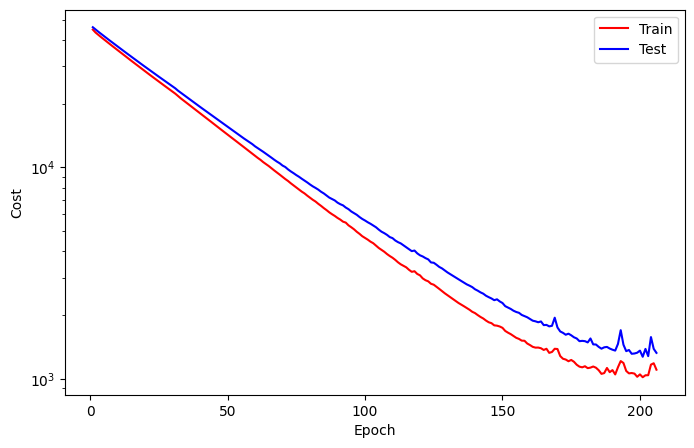

In [16]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

In [17]:
# Define train forecast set and create train forecast loader
train_forecast_set = TimeSeriesDataset(ts_train, 'oil_prod_cum', 1)
trainforecastloader = DataLoader(train_forecast_set)

# Define test forecast set and create test forecast loader
test_forecast_set = TimeSeriesDataset(ts_test, 'oil_prod_cum', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (84699, 1, 8)
Note: last 0 data excluded

(N, S, F): (36299, 1, 8)
Note: last 0 data excluded



In [18]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions
train_predictions = []
test_predictions = []

# Generate predictions for training dataset
with torch.no_grad():
    for feature, target in tqdm(trainforecastloader, desc="Generating Training Predictions"):
        feature, target = feature.to(device), target.to(device)
        output, _ = model(feature, None)
        train_predictions.extend(output)

# Generate predictions for testing dataset
with torch.no_grad():
    for feature, target in tqdm(testforecastloader, desc="Generating Testing Predictions"):
        feature, target = feature.to(device), target.to(device)
        output, _ = model(feature, None)
        test_predictions.extend(output)

# Now you have the train_predictions and test_predictions lists
# You can use these lists for analysis, visualization, or further processing

Generating Training Predictions:   0%|          | 0/84699 [00:00<?, ?it/s]

Generating Testing Predictions:   0%|          | 0/36299 [00:00<?, ?it/s]

In [19]:
# Remove the last row from ts_train
ts_train = ts_train.iloc[:-1]

# Remove the last row from ts_train
ts_test = ts_test.iloc[:-1]
ts_train.shape, ts_test.shape

((84699, 8), (36299, 8))

In [20]:
import pandas as pd

# Convert train_predictions and test_predictions to lists of floats
train_pred_list = [pred.item() for pred in train_predictions]
test_pred_list = [pred.item() for pred in test_predictions]

# Add the new columns to the datasets
ts_train['predicted_oil'] = train_pred_list
ts_test['predicted_oil'] = test_pred_list

# Now ts_train and ts_test have the "predicted_oil" column containing the predictions

<ipython-input-20-f5007dcc696e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_train['predicted_oil'] = train_pred_list
<ipython-input-20-f5007dcc696e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_test['predicted_oil'] = test_pred_list


In [21]:
ts_test.head()

days  oil_prod_cum      Kh_Kv     inj_rate  permeability  porosity  \
years                                                                          
0.000000     0        0.0000  30.131087  1169.818916    275.721455  0.125615   
0.084932    31       26.6338  30.131087  1169.818916    275.721455  0.125615   
0.169863    62       47.1917  30.131087  1169.818916    275.721455  0.125615   
0.254795    93       64.5124  30.131087  1169.818916    275.721455  0.125615   
0.339726   124       79.2770  30.131087  1169.818916    275.721455  0.125615   

            prod_bhp  thickness  predicted_oil  
years                                           
0.000000  331.130088  72.276135      -2.919847  
0.084932  331.130088  72.276135      33.915291  
0.169863  331.130088  72.276135     117.323143  
0.254795  331.130088  72.276135     124.205612  
0.339726  331.130088  72.276135     126.611908

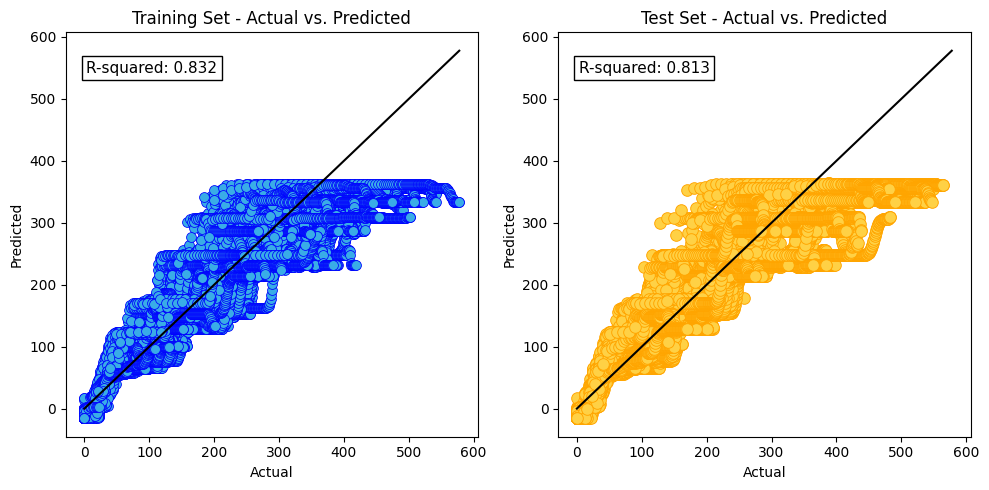

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R-squared scores
train_r2 = r2_score(ts_train["oil_prod_cum"], ts_train["predicted_oil"])
test_r2 = r2_score(ts_test["oil_prod_cum"], ts_test["predicted_oil"])

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': ts_train["oil_prod_cum"], 'Predicted': ts_train["predicted_oil"]})
test_data = pd.DataFrame({'Actual': ts_test["oil_prod_cum"], 'Predicted': ts_test["predicted_oil"]})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0], s=50, color='#39ACE7', edgecolor='blue')
axes[0].set_title('Training Set - Actual vs. Predicted')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(ts_train["oil_prod_cum"].max(), ts_test["oil_prod_cum"].max())],
             [0, max(ts_train["oil_prod_cum"].max(), ts_test["oil_prod_cum"].max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1], s=70, color='#ffd145', edgecolor='orange')
axes[1].set_title('Test Set - Actual vs. Predicted')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(ts_train["oil_prod_cum"].max(), ts_test["oil_prod_cum"].max())],
             [0, max(ts_train["oil_prod_cum"].max(), ts_test["oil_prod_cum"].max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [29]:
from utils import data4pred, pred4pred

ModuleNotFoundError: ignored

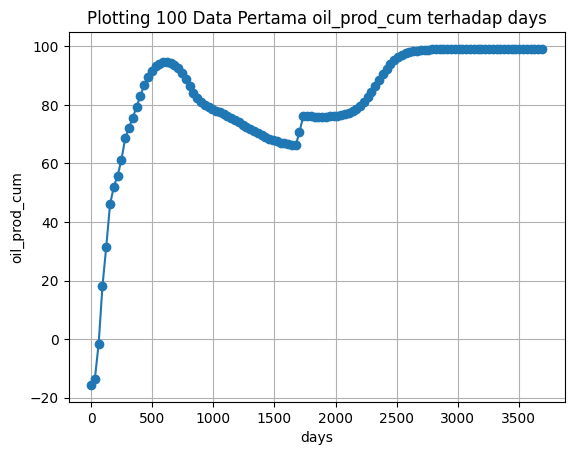

In [31]:
# Mengambil 100 data pertama dari kolom "oil_prod_cum" dan "days"
first_100_oil_prod_cum = ts_train['predicted_oil'].head(120)
first_100_days = ts_train['days'].head(120)

# Melakukan plotting
plt.plot(first_100_days, first_100_oil_prod_cum, marker='o')
plt.title('Plotting 100 Data Pertama oil_prod_cum terhadap days')
plt.xlabel('days')
plt.ylabel('oil_prod_cum')
plt.grid(True)
plt.show()

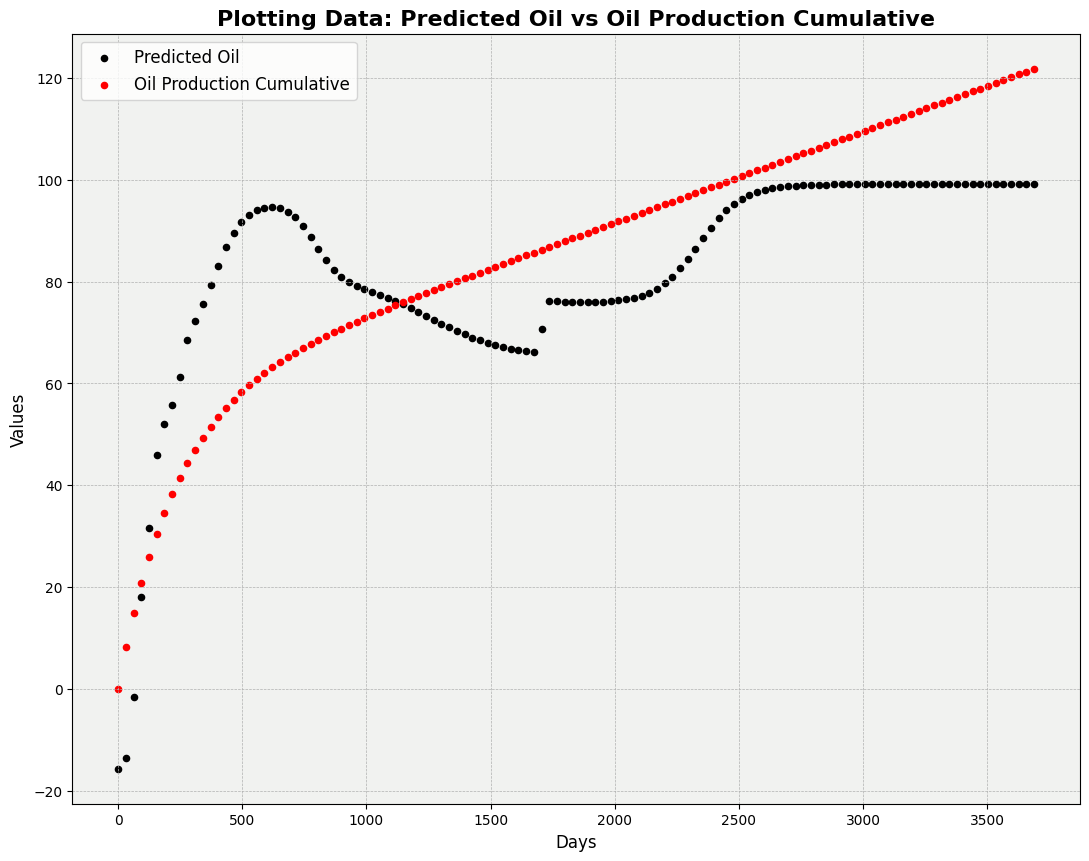

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Ambil 120 data pertama dari kolom "predicted_oil" dan "oil_prod_cum"
plot_1 = ts_train['predicted_oil'].head(120)
plot_2 = ts_train['oil_prod_cum'].head(120)
days = ts_train['days'].head(120)

# Membuat figure dan axis
fig, ax1 = plt.subplots(figsize=(13, 10))

# Scatter plot untuk "predicted_oil" terhadap days
ax1.scatter(days, plot_1, color='black', s=20, label='Predicted Oil', marker='o')

# Scatter plot untuk "oil_prod_cum" terhadap days
ax1.scatter(days, plot_2, color='red', s=20, label='Oil Production Cumulative', marker='o')

ax1.set_xlabel('Days', fontsize=12)
ax1.set_ylabel('Values', fontsize=12)

# Tambahkan gridlines
ax1.grid(True, linestyle='--', linewidth=0.5)

# Sesuaikan ukuran dan gaya font judul
plt.title('Plotting Data: Predicted Oil vs Oil Production Cumulative', fontsize=16, fontweight='bold')

# Sesuaikan ukuran font legenda
plt.legend(loc='upper left', fontsize=12)

# Sesuaikan ukuran label pada sumbu x dan y
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Tambahkan warna latar belakang
ax1.set_facecolor('#F1F2F0')

plt.show()
